## 1. Data Preparation

### 1.1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import time

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV , KFold
from sklearn.metrics import mean_squared_error 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge , ElasticNet , Lasso
from sklearn.ensemble import RandomForestRegressor  , AdaBoostRegressor 

- Import data, check for comlumns and variables
### 1.2. Load and Clean Data
Load the dataset, inspect its structure, and perform initial cleaning. We drop the original 'Price' column (in Toman) and use 'Price(USD)' for our analysis, renaming it to 'Price'.

In [2]:
houses = pd.read_csv("./data/housePrice.csv")
houses = houses.drop('Price', axis=1)
houses = houses.rename(columns={'Price(USD)': 'Price'})
houses.info()
houses.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Area       3479 non-null   object 
 1   Room       3479 non-null   int64  
 2   Parking    3479 non-null   bool   
 3   Warehouse  3479 non-null   bool   
 4   Elevator   3479 non-null   bool   
 5   Address    3456 non-null   object 
 6   Price      3479 non-null   float64
dtypes: bool(3), float64(1), int64(1), object(2)
memory usage: 119.0+ KB


,Area,Room,Parking,Warehouse,Elevator,Address,Price
0,63,1,True,True,True,Shahran,61666.67
1,60,1,True,True,True,Shahran,61666.67
2,79,2,True,True,True,Pardis,18333.33
3,95,2,True,True,True,Shahrake Qods,30083.33
4,123,2,True,True,True,Shahrake Gharb,233333.33


- Since the Address column has some missing data in certain rows, we will drop these rows.

In [3]:
houses = houses.dropna(subset=['Address'])

- Check the header again

In [4]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3456 entries, 0 to 3478
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Area       3456 non-null   object 
 1   Room       3456 non-null   int64  
 2   Parking    3456 non-null   bool   
 3   Warehouse  3456 non-null   bool   
 4   Elevator   3456 non-null   bool   
 5   Address    3456 non-null   object 
 6   Price      3456 non-null   float64
dtypes: bool(3), float64(1), int64(1), object(2)
memory usage: 145.1+ KB


- That said, the data is now complete. HOWEVER, we have not yet categorized the data into the two main types: Numerical and Categorical. Now, we will do that.

In [5]:
# Convert specified columns to categorical data type
houses['Room'] = houses['Room'].astype('category')
houses['Parking'] = houses['Parking'].astype('category')
houses['Warehouse'] = houses['Warehouse'].astype('category')
houses['Elevator'] = houses['Elevator'].astype('category')

# Fix 'Area' datatype
houses['Area'] = pd.to_numeric(houses['Area'], errors='coerce')
houses = houses.dropna(subset=['Area'])
# Verify the changes
print("Data types after conversion:")
print(houses.dtypes)
houses.info()

Data types after conversion:
Area          float64
Room         category
Parking      category
Warehouse    category
Elevator     category
Address        object
Price         float64
dtype: object
<class 'pandas.core.frame.DataFrame'>
Index: 3450 entries, 0 to 3478
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Area       3450 non-null   float64 
 1   Room       3450 non-null   category
 2   Parking    3450 non-null   category
 3   Warehouse  3450 non-null   category
 4   Elevator   3450 non-null   category
 5   Address    3450 non-null   object  
 6   Price      3450 non-null   float64 
dtypes: category(4), float64(2), object(1)
memory usage: 121.7+ KB


### 1.3. Outlier Removal
To prevent extreme values from skewing the analysis, we remove the top and bottom 1% of properties based on price.

In [ ]:
# Calculate 1st and 99th percentiles
lower_percentile = houses['Price'].quantile(0.01)
upper_percentile = houses['Price'].quantile(0.99) # !!!

print(f"1st percentile (1% lowest): ${lower_percentile:.2f}")
print(f"99th percentile (1% highest): ${upper_percentile:.2f}")

# Remove outliers
houses_before = len(houses)
houses = houses[(houses['Price'] >= lower_percentile) & (houses['Price'] <= upper_percentile)]
houses_after = len(houses)

print(f"\nDataset size before removing outliers: {houses_before}")
print(f"Dataset size after removing outliers: {houses_after}")
print(f"Removed {houses_before - houses_after} outliers ({((houses_before - houses_after) / houses_before * 100):.1f}%)")

1st percentile (1% lowest): $9833.33
99th percentile (1% highest): $3080000.00

Dataset size before removing outliers: 3450
Dataset size after removing outliers: 3422
Removed 28 outliers (0.8%)


## 2. Feature Engineering & Data Preprocessing

- Convert the True/False values in the amenities to 0/1.

In [7]:
# Convert True/False values to 1/0 for utility features
houses['Parking'] = houses['Parking'].astype(int)
houses['Warehouse'] = houses['Warehouse'].astype(int)
houses['Elevator'] = houses['Elevator'].astype(int)

    # Display the updated dataframe
houses.tail()

,Area,Room,Parking,Warehouse,Elevator,Address,Price
3474,86.0,2,1,1,1,Southern Janatabad,116666.67
3475,83.0,2,1,1,1,Niavaran,226666.67
3476,75.0,2,0,0,0,Parand,12166.67
3477,105.0,2,1,1,1,Dorous,186666.67
3478,82.0,2,0,1,1,Parand,12000.00


In [8]:
# Create categorical features using get_dummies for Address, Area_Group, and Price_Group
categorical_features = pd.get_dummies(houses[["Address"]])
houses = houses.merge(categorical_features, left_index=True, right_index=True)
houses.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Address_Abazar,Address_Abbasabad,Address_Absard,...,Address_Waterfall,Address_West Ferdows Boulevard,Address_West Pars,Address_Yaftabad,Address_Yakhchiabad,Address_Yousef Abad,Address_Zafar,Address_Zaferanieh,Address_Zargandeh,Address_Zibadasht
0,63.0,1,1,1,1,Shahran,61666.67,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,60.0,1,1,1,1,Shahran,61666.67,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,79.0,2,1,1,1,Pardis,18333.33,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,95.0,2,1,1,1,Shahrake Qods,30083.33,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,123.0,2,1,1,1,Shahrake Gharb,233333.33,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [9]:
prepared_dataset = houses.drop(["Address"], axis=1)
prepared_dataset.head()

,Area,Room,Parking,Warehouse,Elevator,Price,Address_Abazar,Address_Abbasabad,Address_Absard,Address_Abuzar,...,Address_Waterfall,Address_West Ferdows Boulevard,Address_West Pars,Address_Yaftabad,Address_Yakhchiabad,Address_Yousef Abad,Address_Zafar,Address_Zaferanieh,Address_Zargandeh,Address_Zibadasht
0,63.0,1,1,1,1,61666.67,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,60.0,1,1,1,1,61666.67,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,79.0,2,1,1,1,18333.33,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,95.0,2,1,1,1,30083.33,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,123.0,2,1,1,1,233333.33,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


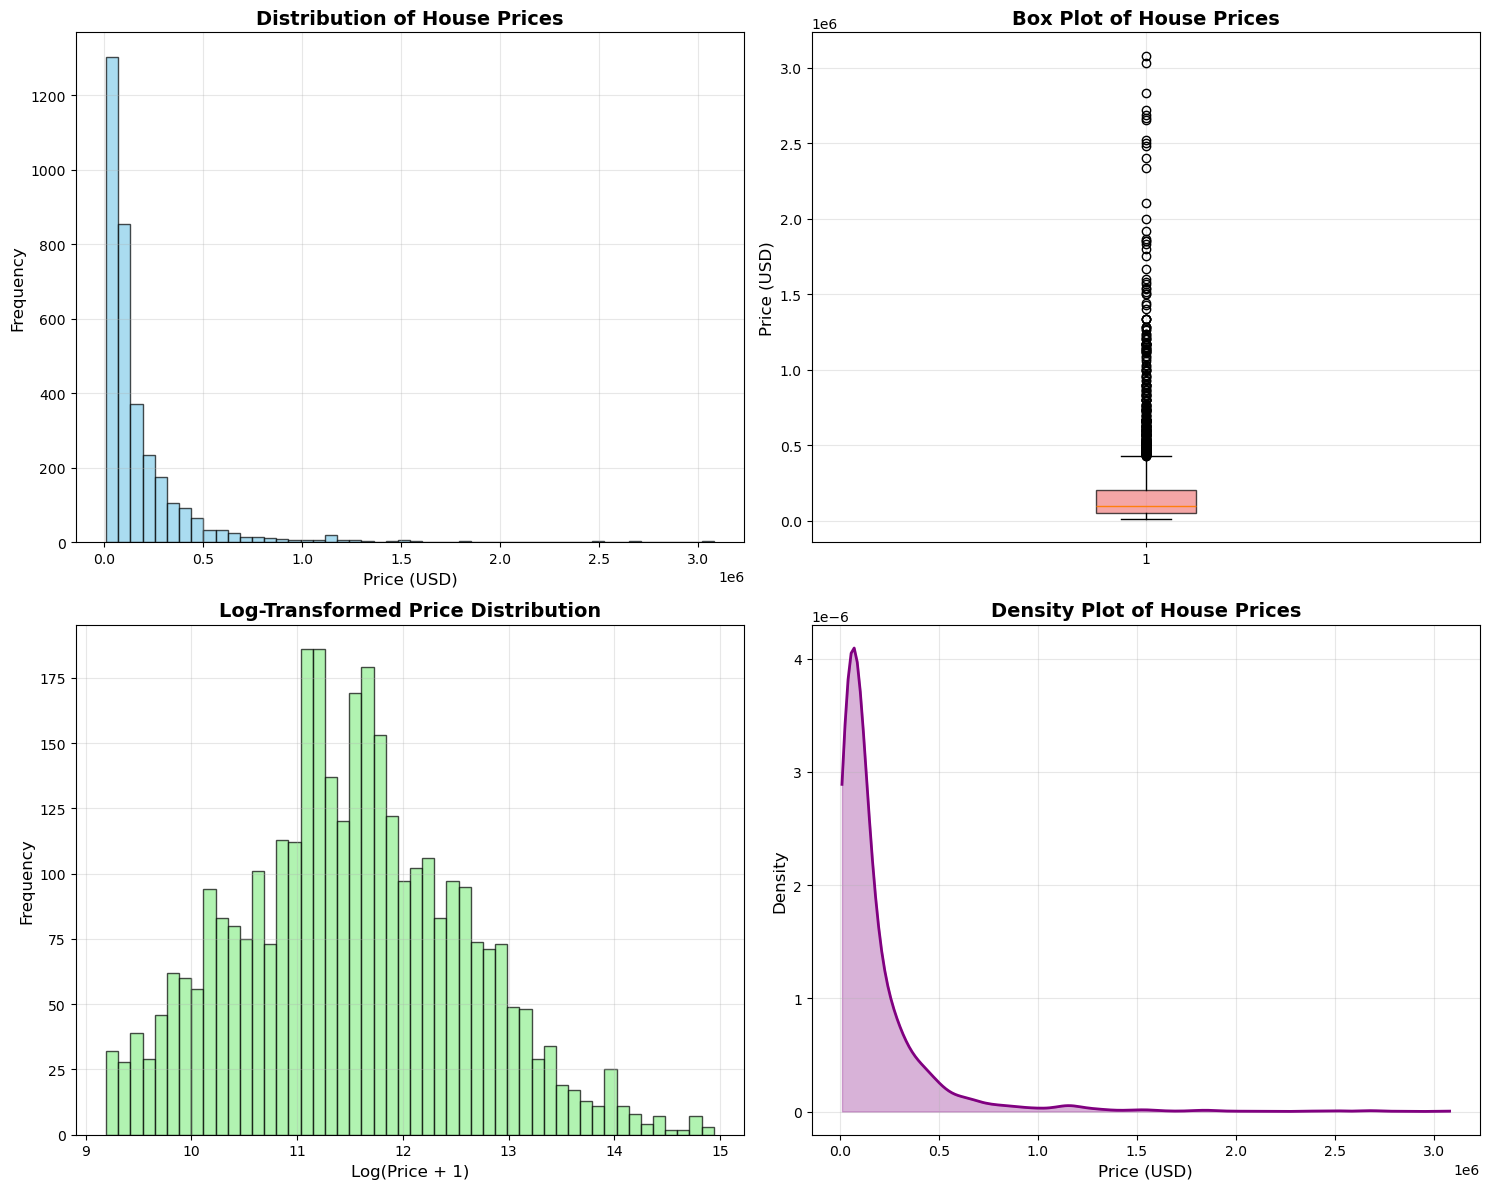

PRICE DISTRIBUTION STATISTICS
Count: 3,422
Mean: $180,593.64
Median: $97,666.67
Standard Deviation: $271,520.34
Minimum: $9,833.33
Maximum: $3,080,000.00
25th Percentile: $48,416.67
75th Percentile: $200,000.00
Skewness: 4.758
Kurtosis: 32.075

PRICE RANGE ANALYSIS
Budget ($0-$50K): 862 properties (25.2%)
Mid-range ($50K-$100K): 875 properties (25.6%)
Premium ($100K-$200K): 801 properties (23.4%)
Luxury ($200K-$500K): 654 properties (19.1%)
Ultra-luxury ($500K+): 230 properties (6.7%)


In [10]:
from scipy.stats import gaussian_kde

# Create visualizations for the price distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Histogram of price distribution
axes[0, 0].hist(prepared_dataset['Price'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of House Prices', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Price (USD)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)

# 2. Box plot to show outliers and quartiles
axes[0, 1].boxplot(prepared_dataset['Price'], vert=True, patch_artist=True, 
                   boxprops=dict(facecolor='lightcoral', alpha=0.7))
axes[0, 1].set_title('Box Plot of House Prices', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Price (USD)', fontsize=12)
axes[0, 1].grid(True, alpha=0.3)

# 3. Log-transformed price distribution
log_prices = np.log1p(prepared_dataset['Price'])  # log1p to handle zeros if any
axes[1, 0].hist(log_prices, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Log-Transformed Price Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Log(Price + 1)', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)

# 4. Density plot (KDE)
density = gaussian_kde(prepared_dataset['Price'])
xs = np.linspace(prepared_dataset['Price'].min(), prepared_dataset['Price'].max(), 200)
axes[1, 1].plot(xs, density(xs), color='purple', linewidth=2)
axes[1, 1].fill_between(xs, density(xs), alpha=0.3, color='purple')
axes[1, 1].set_title('Density Plot of House Prices', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Price (USD)', fontsize=12)
axes[1, 1].set_ylabel('Density', fontsize=12)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistical summary
print("PRICE DISTRIBUTION STATISTICS")
print("=" * 50)
print(f"Count: {prepared_dataset['Price'].count():,}")
print(f"Mean: ${prepared_dataset['Price'].mean():,.2f}")
print(f"Median: ${prepared_dataset['Price'].median():,.2f}")
print(f"Standard Deviation: ${prepared_dataset['Price'].std():,.2f}")
print(f"Minimum: ${prepared_dataset['Price'].min():,.2f}")
print(f"Maximum: ${prepared_dataset['Price'].max():,.2f}")
print(f"25th Percentile: ${prepared_dataset['Price'].quantile(0.25):,.2f}")
print(f"75th Percentile: ${prepared_dataset['Price'].quantile(0.75):,.2f}")
print(f"Skewness: {prepared_dataset['Price'].skew():.3f}")
print(f"Kurtosis: {prepared_dataset['Price'].kurtosis():.3f}")

# Additional insights
print("\nPRICE RANGE ANALYSIS")
print("=" * 50)
price_ranges = [
    (0, 50000, "Budget ($0-$50K)"),
    (50000, 100000, "Mid-range ($50K-$100K)"),
    (100000, 200000, "Premium ($100K-$200K)"),
    (200000, 500000, "Luxury ($200K-$500K)"),
    (500000, float('inf'), "Ultra-luxury ($500K+)")
]

for min_price, max_price, label in price_ranges:
    count = len(prepared_dataset[(prepared_dataset['Price'] >= min_price) & 
                                (prepared_dataset['Price'] < max_price)])
    percentage = (count / len(prepared_dataset)) * 100
    print(f"{label}: {count:,} properties ({percentage:.1f}%)")

## 3. Model training

In [11]:
from sklearn.preprocessing import MinMaxScaler

# Define features (X) and target (y)
X = prepared_dataset.drop(["Price"], axis=1)
y = prepared_dataset["Price"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2006)

# Initialize the MinMaxScaler to scale features to a 0-1 range
scaler = MinMaxScaler()

# Fit on training data and transform both train and test data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Data split and scaled with MinMaxScaler. Ready for training.")

Data split and scaled with MinMaxScaler. Ready for training.


### 3.1. Feature Scaling

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

- Train shape

In [13]:
print("X Train and Test shape:")
print(f'X_train : {X_train.shape}')
print(f'X_test  : {X_test.shape}')
print("---" * 30)
print("y Train and Test shape:")
print(f'y_train : {y_train.shape}')
print(f'y_test  : {y_test.shape}')
print("---" * 30)

# Also print the feature count and sample count
print("Dataset Summary:")
print(f"Total samples: {len(X_train) + len(X_test)}")
print(f"Training samples: {len(X_train)} ({len(X_train)/(len(X_train) + len(X_test)):.2%})")
print(f"Testing samples: {len(X_test)} ({len(X_test)/(len(X_train) + len(X_test)):.2%})")
print(f"Number of features: {X_train.shape[1]}")

X Train and Test shape:
X_train : (2737, 196)
X_test  : (685, 196)
------------------------------------------------------------------------------------------
y Train and Test shape:
y_train : (2737,)
y_test  : (685,)
------------------------------------------------------------------------------------------
Dataset Summary:
Total samples: 3422
Training samples: 2737 (79.98%)
Testing samples: 685 (20.02%)
Number of features: 196


- Save the index and performance of each type of model on the dataset.

In [14]:
Model_Name  = []
Train_Score = []
Test_Score  = []
MSE_Score   = []
RMSE_Score  = []
Time_Score  = []

In [15]:
from sklearn.metrics import mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error (MAPE)"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def model_prediction(model):
    
    start_time = time.time()
    model.fit(X_train, y_train)
    y_prediction = model.predict(X_test)
    y_prediction = [i if i>0 else 0 for i in y_prediction]
    
    # Calculate only MAE and MAPE
    MAEscore = mean_absolute_error(y_test, y_prediction)
    MAPEscore = mean_absolute_percentage_error(y_test, y_prediction)
    
    end_time = time.time()
    Timescore = end_time - start_time
    
    Name = str(model).split('(')[0]
    Model_Name.append(Name)
    Train_Score.append(MAPEscore)  # Store MAPE in Train_Score
    Test_Score.append(MAEscore)    # Store MAE in Test_Score
    MSE_Score.append(MAEscore)     # Store MAE in MSE_Score for compatibility
    RMSE_Score.append(MAPEscore)   # Store MAPE in RMSE_Score for compatibility
    Time_Score.append(Timescore)

    print(f'Model: {Name}')
    print('=' * 50)
    print(f'Mean Absolute Error (MAE): ${MAEscore:,.0f}')
    print(f'Mean Absolute Percentage Error (MAPE): {MAPEscore:.2f}%')
    print('=' * 50)
    print(f'Training Time: {Timescore:.3f} seconds')
    print('\n')


1.  Regression Model

In [16]:
model_prediction(ElasticNet())

Model: ElasticNet
Mean Absolute Error (MAE): $65,484
Mean Absolute Percentage Error (MAPE): 75.15%
Training Time: 0.047 seconds




In [17]:
model_prediction(Lasso())

Model: Lasso
Mean Absolute Error (MAE): $58,924
Mean Absolute Percentage Error (MAPE): 53.55%
Training Time: 1.356 seconds




c:\Users\ducho\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.514e+12, tolerance: 2.178e+10
  model = cd_fast.enet_coordinate_descent(


In [18]:
model_prediction(Ridge())

Model: Ridge
Mean Absolute Error (MAE): $58,990
Mean Absolute Percentage Error (MAPE): 53.70%
Training Time: 0.048 seconds




In [19]:
model_prediction(LinearRegression())
model_prediction(KNeighborsRegressor())
model_prediction(DecisionTreeRegressor())
model_prediction(RandomForestRegressor())
model_prediction(AdaBoostRegressor())

Model: LinearRegression
Mean Absolute Error (MAE): $59,124
Mean Absolute Percentage Error (MAPE): 52.54%
Training Time: 0.075 seconds


Model: KNeighborsRegressor
Mean Absolute Error (MAE): $44,055
Mean Absolute Percentage Error (MAPE): 33.18%
Training Time: 0.306 seconds


Model: DecisionTreeRegressor
Mean Absolute Error (MAE): $52,877
Mean Absolute Percentage Error (MAPE): 35.42%
Training Time: 0.068 seconds


Model: RandomForestRegressor
Mean Absolute Error (MAE): $48,591
Mean Absolute Percentage Error (MAPE): 34.52%
Training Time: 2.399 seconds


Model: AdaBoostRegressor
Mean Absolute Error (MAE): $257,856
Mean Absolute Percentage Error (MAPE): 494.56%
Training Time: 0.897 seconds




In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
import warnings

# Perform cross-validation for all models
warnings.filterwarnings('ignore')

# Define models to test
models = [
    ElasticNet(),
    Lasso(),
    Ridge(),
    LinearRegression(),
    KNeighborsRegressor(),
    DecisionTreeRegressor(),
    RandomForestRegressor()
]

# Store cross-validation results
cv_results = {
    'Model': [],
    'Mean MAE': [],
    'Std MAE': [],
    'Mean MAPE (%)': [],
    'Std MAPE (%)': [],
    'Mean Training Time (s)': []
}

# Create MAPE scorer
def mape_scorer(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_score = make_scorer(mape_scorer, greater_is_better=False)

print("Cross-Validation Results (MAE & MAPE):")
print("=" * 80)

for model in models:
    model_name = str(model).split('(')[0]
    print(f"\nEvaluating {model_name}...")
    
    start_time = time.time()
    
    # Perform 5-fold cross-validation for MAE
    cv_mae_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    cv_mae_scores = -cv_mae_scores  # Convert to positive MAE
    
    # Perform 5-fold cross-validation for MAPE
    cv_mape_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=mape_score)
    cv_mape_scores = -cv_mape_scores  # Convert to positive MAPE
    
    end_time = time.time()
    training_time = (end_time - start_time) / 5  # Average time per fold
    
    # Store results
    cv_results['Model'].append(model_name)
    cv_results['Mean MAE'].append(cv_mae_scores.mean())
    cv_results['Std MAE'].append(cv_mae_scores.std())
    cv_results['Mean MAPE (%)'].append(cv_mape_scores.mean())
    cv_results['Std MAPE (%)'].append(cv_mape_scores.std())
    cv_results['Mean Training Time (s)'].append(training_time)
    
    print(f"Mean MAE: ${cv_mae_scores.mean():,.0f} (±${cv_mae_scores.std():,.0f})")
    print(f"Mean MAPE: {cv_mape_scores.mean():.2f}% (±{cv_mape_scores.std():.2f}%)")
    print(f"Average Training Time: {training_time:.3f} seconds")

# Convert to DataFrame for better visualization
cv_df = pd.DataFrame(cv_results)
cv_df['Mean MAE'] = cv_df['Mean MAE'].apply(lambda x: f"${x:,.0f}")
cv_df['Std MAE'] = cv_df['Std MAE'].apply(lambda x: f"±${x:,.0f}")
cv_df['Mean MAPE (%)'] = cv_df['Mean MAPE (%)'].apply(lambda x: f"{x:.2f}%")
cv_df['Std MAPE (%)'] = cv_df['Std MAPE (%)'].apply(lambda x: f"±{x:.2f}%")

# Sort by MAPE (convert back to float for sorting)
cv_df_sorted = cv_df.copy()
cv_df_sorted['MAPE_numeric'] = [float(score.split('%')[0]) for score in cv_df['Mean MAPE (%)']]
cv_df_sorted = cv_df_sorted.sort_values('MAPE_numeric', ascending=True).drop('MAPE_numeric', axis=1)

print("\n" + "=" * 80)
print("CROSS-VALIDATION SUMMARY (Sorted by MAPE - Lower is Better):")
print("=" * 80)
print(cv_df_sorted.to_string(index=False))

Cross-Validation Results (MAE & MAPE):

Evaluating ElasticNet...
Mean MAE: $76,918 (±$3,880)
Mean MAPE: 86.61% (±3.20%)
Average Training Time: 0.070 seconds

Evaluating Lasso...
Mean MAE: $71,998 (±$5,154)
Mean MAPE: 79.47% (±7.11%)
Average Training Time: 1.230 seconds

Evaluating Ridge...
Mean MAE: $72,094 (±$5,118)
Mean MAPE: 79.70% (±7.09%)
Average Training Time: 0.042 seconds

Evaluating LinearRegression...
Mean MAE: $2,749,998,944,269,267,968 (±$2,053,482,714,798,029,568)
Mean MAPE: 5834075539772322.00% (±4732239725988341.00%)
Average Training Time: 0.082 seconds

Evaluating KNeighborsRegressor...
Mean MAE: $56,972 (±$3,001)
Mean MAPE: 37.97% (±1.99%)
Average Training Time: 0.068 seconds

Evaluating DecisionTreeRegressor...
Mean MAE: $56,277 (±$8,413)
Mean MAPE: 40.34% (±7.86%)
Average Training Time: 0.085 seconds

Evaluating RandomForestRegressor...


In [ ]:
from scipy import stats

# Perform statistical comparison between RandomForest and other models using MAE
print("Statistical Comparison: RandomForestRegressor vs Other Models (MAE)")
print("=" * 70)

# Get RandomForest cross-validation scores using MAE
rf_model = RandomForestRegressor(random_state=42)
rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
rf_cv_scores = -rf_cv_scores  # Convert to positive MAE

print(f"RandomForest CV MAE Scores: {rf_cv_scores}")
print(f"RandomForest Mean MAE: ${rf_cv_scores.mean():,.0f} (±${rf_cv_scores.std():,.0f})")
print()

# Compare with other top models
comparison_models = [
    ('KNeighborsRegressor', KNeighborsRegressor()),
    ('Lasso', Lasso(random_state=42)),
    ('Ridge', Ridge(random_state=42)),
    ('DecisionTreeRegressor', DecisionTreeRegressor(random_state=42))
]

for model_name, model in comparison_models:
    # Get CV MAE scores for comparison model
    model_cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    model_cv_scores = -model_cv_scores  # Convert to positive MAE
    
    # Perform paired t-test (lower MAE is better, so we compare model_cv_scores vs rf_cv_scores)
    t_stat, p_value = stats.ttest_rel(model_cv_scores, rf_cv_scores)
    
    # Calculate effect size (Cohen's d) - negative means RandomForest is better (lower MAE)
    pooled_std = np.sqrt((rf_cv_scores.var() + model_cv_scores.var()) / 2)
    cohens_d = (model_cv_scores.mean() - rf_cv_scores.mean()) / pooled_std
    
    print(f"RandomForest vs {model_name}:")
    print(f"  {model_name} Mean MAE: ${model_cv_scores.mean():,.0f} (±${model_cv_scores.std():,.0f})")
    print(f"  MAE Difference: ${model_cv_scores.mean() - rf_cv_scores.mean():,.0f}")
    print(f"  T-statistic: {t_stat:.4f}")
    print(f"  P-value: {p_value:.4f}")
    print(f"  Cohen's d: {cohens_d:.4f}")
    
    # Interpret results
    if p_value < 0.01:
        significance = "highly significant (p < 0.01)"
    elif p_value < 0.05:
        significance = "significant (p < 0.05)"
    else:
        significance = "not significant (p >= 0.05)"
    
    if abs(cohens_d) < 0.2:
        effect_size = "small"
    elif abs(cohens_d) < 0.5:
        effect_size = "medium"
    else:
        effect_size = "large"
    
    if cohens_d < 0:
        print(f"  Result: RandomForest is {significance} better with {effect_size} effect size")
    else:
        print(f"  Result: {model_name} performs {significance} better with {effect_size} effect size")
    print("-" * 50)

# Calculate MAPE scores for all models
print("\nMAPE Comparison:")
print("=" * 50)

# MAPE scoring function
def mape_scorer(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_score_func = make_scorer(mape_scorer, greater_is_better=False)

# Get RandomForest MAPE scores
rf_mape_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring=mape_score_func)
rf_mape_scores = -rf_mape_scores  # Convert to positive MAPE

print(f"RandomForest Mean MAPE: {rf_mape_scores.mean():.2f}% (±{rf_mape_scores.std():.2f}%)")

for model_name, model in comparison_models:
    # Get MAPE scores for comparison model
    model_mape_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=mape_score_func)
    model_mape_scores = -model_mape_scores  # Convert to positive MAPE
    
    print(f"{model_name} Mean MAPE: {model_mape_scores.mean():.2f}% (±{model_mape_scores.std():.2f}%)")
    print(f"  MAPE Difference: {model_mape_scores.mean() - rf_mape_scores.mean():.2f}%")

# Overall conclusion
print("\nCONCLUSION:")
print("=" * 70)
best_competitor = min(comparison_models, key=lambda x: (-cross_val_score(x[1], X_train, y_train, cv=5, scoring='neg_mean_absolute_error')).mean())
competitor_scores = cross_val_score(best_competitor[1], X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
competitor_scores = -competitor_scores  # Convert to positive MAE
final_t_stat, final_p_value = stats.ttest_rel(competitor_scores, rf_cv_scores)

if final_p_value < 0.05 and rf_cv_scores.mean() < competitor_scores.mean():
    print(f"✅ RandomForestRegressor significantly outperforms all other models")
    print(f"   Best competitor: {best_competitor[0]} (Mean MAE: ${competitor_scores.mean():,.0f})")
    print(f"   RandomForest advantage: ${competitor_scores.mean() - rf_cv_scores.mean():,.0f} lower MAE")
    print(f"   Statistical significance: p = {final_p_value:.4f}")
else:
    print(f"❌ RandomForestRegressor does not significantly outperform all models")
    print(f"   Best competitor: {best_competitor[0]} performs similarly or better")
    print(f"   Best competitor MAE: ${competitor_scores.mean():,.0f}")
    print(f"   RandomForest MAE: ${rf_cv_scores.mean():,.0f}")